# 3D Mesh Interpolation

Authors: Shiva Peri, Hima Gururaj, Nikolas Diamant

Paper References: 
[Lipschitz Regularization](https://arxiv.org/pdf/2202.08345v1.pdf),
[DeepSDF](https://arxiv.org/pdf/1901.05103.pdf)

Code References:
[Mesh to SDF](https://github.com/marian42/mesh_to_sdf),
[DeepSDF](https://github.com/facebookresearch/DeepSDF),

#### Importing Libraries

In [1]:
# use these specific versions so pytorch3d doesnt break

!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.6.0+cu101 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.6.0+cu101 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 5.9 MB 24.9 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Unin

In [2]:
%matplotlib inline

import os
import sys
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.distributions.bernoulli import Bernoulli

from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [3]:
import pytorch3d

from pytorch3d.renderer import (
    OpenGLPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    TexturesVertex,
    look_at_view_transform,

    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

from pytorch3d.structures import (
    Meshes,
    Pointclouds
)

In [4]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2022-05-09 23:12:14--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2022-05-09 23:12:14 (30.5 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [5]:
!pip install mesh-to-sdf

from mesh_to_sdf import sample_sdf_near_surface

import trimesh
import skimage
import skimage.measure

     |████████████████████████████████| 1.2 MB 4.1 MB/s 
     |████████████████████████████████| 978 kB 60.7 MB/s 
     |████████████████████████████████| 2.2 MB 45.0 MB/s 
     |████████████████████████████████| 646 kB 85.8 MB/s 
  Created wheel for pyopengl: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745210 sha256=6e2434a1f6d46f3b30fad6731518fe19ee2fff6cdda9fb3ed87b8cf6c166dd7d
  Stored in directory: /root/.cache/pip/wheels/c6/83/cb/af51a0c06c33d08537b941bbfc87469e8a3c68d05f77a6a212
Successfully built pyopengl
  Attempting uninstall: pyopengl
    Found existing installation: PyOpenGL 3.1.6
    Uninstalling PyOpenGL-3.1.6:
      Successfully uninstalled PyOpenGL-3.1.6


#### Data Loader

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [7]:
#!wget https://github.com/shivaPeri/16726-final-project/blob/main/data2.zip
!unzip ./data2.zip

Archive:  ./data2.zip
  inflating: objects/smoothTube.obj  
  inflating: objects/spikePillar.obj  


In [8]:
class SDFDataset(Dataset):
    def __init__(self, folder='objects', num_pts=250000):

        files = os.listdir(folder)
        self.objectFiles = [ folder + '/' + f for f in files]

        self.num_pts = num_pts
        self.meshes = [trimesh.load(folder + '/' + f) for f in files]
        self.num_meshes = len(self.meshes)

        self.data = np.zeros((self.num_meshes, self.num_pts, self.num_meshes + 3))      # (M, P, M + 3)
        self.targets = np.zeros((self.num_meshes, self.num_pts))                        # (M, P)

        for i, mesh in enumerate(self.meshes):

            # onehot vector for latent code
            self.data[i, :, i] = 1

            # store sampled points
            points, sdfs = sample_sdf_near_surface(mesh, number_of_points=num_pts, surface_point_method='sample')
            print('points min/max', np.min(points), np.max(points), 'sdfs min/max', np.min(sdfs), np.max(sdfs))
            points *= 100
            sdfs *= 100
            self.data[i, :, self.num_meshes: ] = points

            # store ground truth sdf
            self.targets[i] = sdfs
            
        # stack data
        self.data = np.concatenate(self.data, axis=0).astype(np.float32)               # (M * P, M + 3)
        self.targets = np.concatenate(self.targets, axis=0).astype(np.float32)         # (M * P)

    def __len__(self):
        return self.num_pts * self.num_meshes

    def __getitem__(self, i):
        return self.data[i], self.targets[i]

    #TODO
    def render(mesh_idx):
      pass




In [9]:
# # testing dataloader
# dataset = SDFDataset()
# loader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=4)

# print(len(dataset))
# print(dataset.data.shape)
# print(dataset.targets.shape)

#### Initialize Renderer

In [10]:
mesh = trimesh.load('objects/' + os.listdir('objects')[0])
points, sdf = sample_sdf_near_surface(mesh, number_of_points=25000, surface_point_method='sample')
colors = np.zeros(points.shape)
colors[sdf < 0, 2] = 1
colors[sdf > 0, 0] = 1

verts = torch.Tensor(points).to(device)   
rgb = torch.Tensor(colors).to(device)
point_cloud = Pointclouds(points=[verts], features=[rgb])

In [11]:
# Initialize a camera.
R, T = look_at_view_transform(20, -20, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

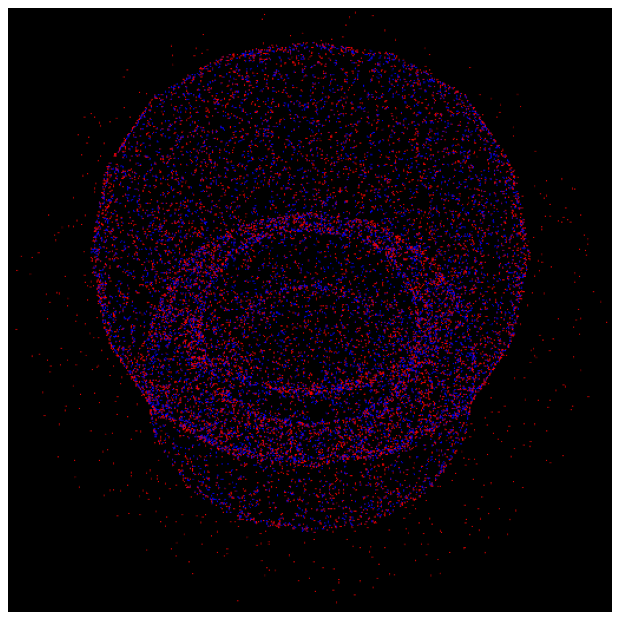

In [12]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

#### Model Architecture

In [13]:
# Modified DeepSDF decoder from https://github.com/facebookresearch/DeepSDF/blob/main/networks/deep_sdf_decoder.py

#https://arxiv.org/pdf/2202.08345v1.pdf page 4
class Lipschitz(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Lipschitz, self).__init__()

        self.lin = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.lin.weight, gain=nn.init.calculate_gain('tanh'))

        Wi = self.lin.weight
        absrowsum = torch.sum(torch.abs(Wi), axis=1)
        self.ci = torch.nn.Parameter(absrowsum, requires_grad=True).to(device)
        
    def forward(self, x):
        Wi = self.lin.weight
        absrowsum = torch.sum(torch.abs(Wi), axis=1)
        scale = torch.min(torch.ones(1).to(device), self.ci/absrowsum)
        
        w = Wi * scale[:,None]
        return F.linear(x, w, self.lin.bias)

class DeepSDFDecoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        use_lip=True,             # this parameter applies Lipschitz
        lipschitz_alpha=1,        # weight of lipschitz losses
        latent_dropout=False,
    ):
        super(DeepSDFDecoder, self).__init__()

        dims = [latent_size + 3] + dims + [1]

        self.use_lip = use_lip
        self.lipschitz_alpha = lipschitz_alpha

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                # Lipschitz layer performes normalized linear layer + tracks losses
                if use_lip:
                    setattr(self, "lin" + str(layer), Lipschitz(dims[layer], out_dim))
                else:
                    setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)              
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x

In [19]:
# model trainer

class Trainer:
    def __init__(self, model, loader, renderer, lr=0.1, max_epochs=1, run_id='exp', alpha=1):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.renderer = renderer
        self.train_losses = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.MSELoss()
        # TODO: try: Dirichlet energy, chamfer loss


    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    # inputs: latent code + xyz coord
    # targets: ground truth sdfs
    def train_batch(self, inputs, targets):
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        self.optimizer.zero_grad()
        outputs = self.model(inputs).squeeze()

        loss = self.criterion(outputs, targets)

        if self.model.use_lip:
          lipschitz_bound = 1
          for layer in range(0, self.model.num_layers - 1):
            lip = getattr(self.model, "lin" + str(layer))
            lipschitz_bound *= lip.ci
          loss += self.model.lipschitz_alpha * lipschitz_bound[0]

        loss.backward()
        self.optimizer.step()
        
        torch.cuda.empty_cache()
        return loss.item()

    
    # TODO
    # latent_code: vector in higher dimensional manifold 
    # n: number of points to sample
    def sample(self, latent_code, n=25000):
        self.model.eval() # set to eval mode
        
        #sample n random pts
        inputs = torch.zeros((n, len(latent_code) + 3))
        points = torch.rand((n, 3))
        points = (points - 0.5) * 2
        print('points min/max', torch.min(points), torch.max(points))
        inputs[:, -3:] = points * 100
        inputs[:, :-3] = latent_code

        sdfs = self.model(inputs) / 100
        print('result sdfs min/max', torch.min(sdfs), torch.max(sdfs))

        colors = np.zeros(points.shape)
        sdfs_neg = sdfs < 0
        sdfs_pos = sdfs > 0
        sdfs_abs = torch.abs(sdfs).cpu().detach().numpy()
        colors[:, 2] = sdfs_neg[:,0]
        colors[:, 1] = sdfs_abs[:,0]
        colors[:, 0] = sdfs_pos[:,0]

        verts = torch.Tensor(points).to(device)   
        rgb = torch.Tensor(colors).to(device)
        point_cloud = Pointclouds(points=[verts], features=[rgb])

        #TODO: sample 64x64x64 voxel grid, create marching cube mesh
        #voxels = np array 64x64x64, sampling sdf within unit cube
        #vertices, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0)
        

        return point_cloud

    # TODO
    def render(self, latent_code, n=25000):
        self.model.eval() # set to eval mode
        
        point_cloud = self.sample(latent_code, n)
        images = renderer(point_cloud)
        plt.figure(figsize=(10, 10))
        plt.imshow(images[0, ..., :3].cpu().numpy())
        plt.axis("off")
        plt.show()

    def plot_loss(self):
        plt.figure()
        plt.plot(range(1, self.epochs + 1), self.train_losses, label='Training losses')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)

#### Training + Evaluation

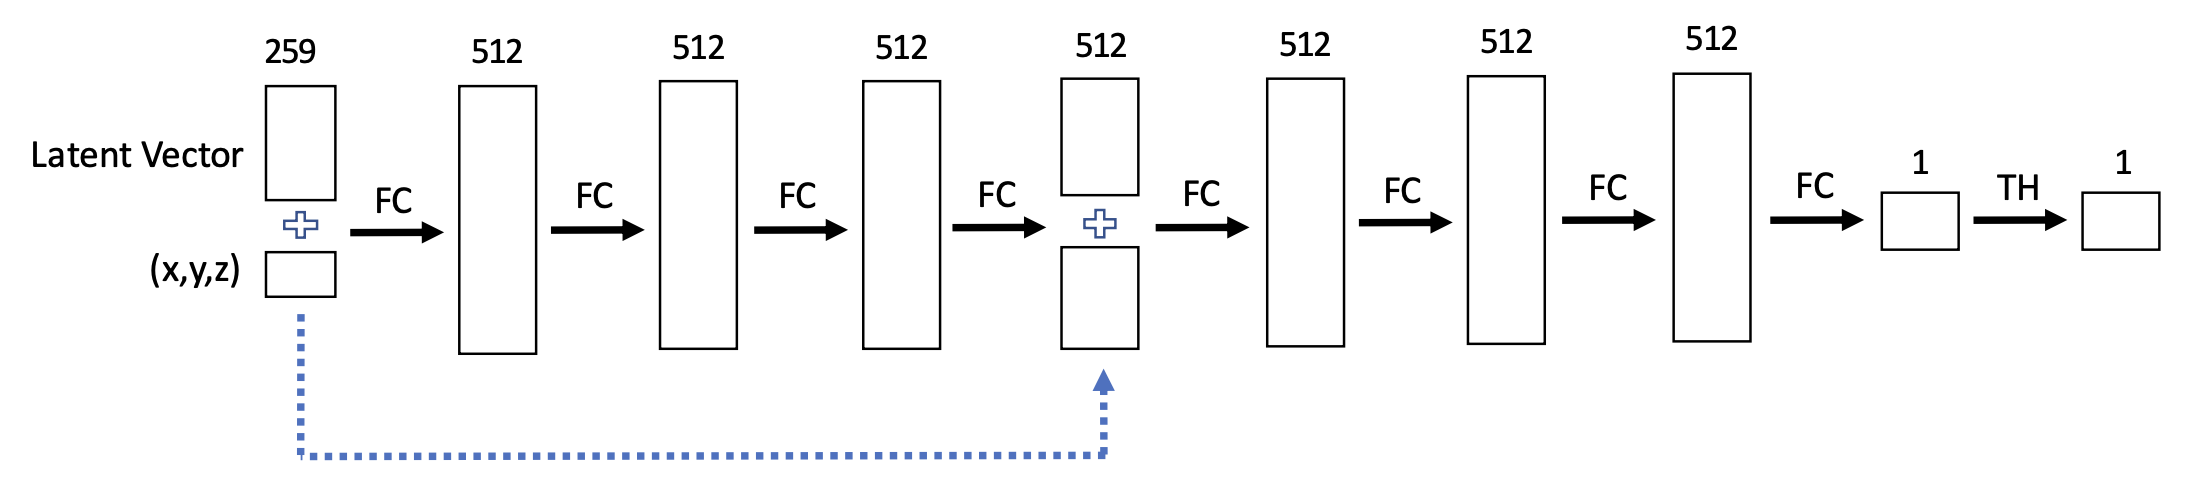

In [15]:
# Dataloader hyperparameters

DATADIR = 'objects'
BATCH_SIZE = 256
NUM_WORKERS = 8
NUM_PTS = 250000

dataset = SDFDataset(folder=DATADIR, num_pts=NUM_PTS)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

points min/max -0.998141 0.99942344 sdfs min/max -0.19983536 0.601019
points min/max -0.99639976 0.9937668 sdfs min/max -0.68978995 0.7331901


In [16]:
# Model hyperparameters

LR = 1e-4
NUM_EPOCHS = 100


# LATENT_DIM = 256
LATENT_DIM = len(os.listdir(DATADIR))
print(LATENT_DIM)

FC_DIM = [512] * 8
DROPOUT = [0, 1, 2, 3, 4, 5, 6, 7]
NORM = [0, 1, 2, 3, 4, 5, 6, 7]
LATENT_IN = [4]

P = 0.2                 # dropout probability
ALPHA = 1E-6            # lipschitz alpha, weight of lipschitz losses

2


In [23]:
model = DeepSDFDecoder(
        LATENT_DIM,
        FC_DIM,
        dropout=DROPOUT,
        dropout_prob=P,
        norm_layers=NORM,
        latent_in=LATENT_IN,
        weight_norm=False,
        xyz_in_all=False,
        use_tanh=True,
        use_lip=True,
        lipschitz_alpha=ALPHA,
        latent_dropout=False,
        ).to(device)

# generate unique run id
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

trainer = Trainer(model, loader, renderer, max_epochs=NUM_EPOCHS, run_id=run_id, lr=LR)
print(trainer.model)

RuntimeError: ignored

In [18]:
# Training Loop
latent_code = torch.tensor(np.array([1,0]))
trainer.render(latent_code)

for epoch in range(NUM_EPOCHS):
    trainer.train()
    trainer.render(latent_code)
    trainer.save()

points min/max tensor(-1.0000) tensor(1.0000)


RuntimeError: ignored

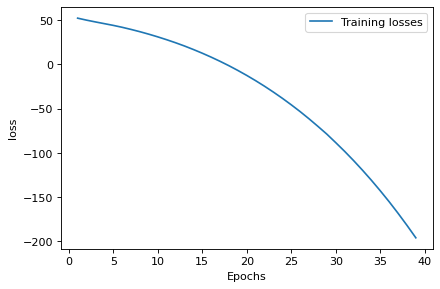

In [129]:
# plot training curves
trainer.plot_loss()

In [ ]:
# see generated output
latent_code = torch.tensor(np.array([1,0]))
trainer.render(latent_code)

IndexError: ignored